In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d mahyeks/almond-varieties

Dataset URL: https://www.kaggle.com/datasets/mahyeks/almond-varieties
License(s): CC0-1.0
 96% 93.0M/96.5M [00:03<00:00, 26.6MB/s]
100% 96.5M/96.5M [00:03<00:00, 25.9MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/almond-varieties.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [21]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [5]:
# Define the path to the augmented images directory
augmented_images_dir = '/content/dataset'

# Define the paths for the train and validation directories
train_dir = '/content/train'
valid_dir = '/content/valid'

In [6]:
# Create train and validation directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

In [7]:
# Define the split ratios
train_ratio = 0.8
valid_ratio = 0.2

In [8]:
# Loop through each class in the augmented dataset
for class_name in os.listdir(augmented_images_dir):
    class_dir = os.path.join(augmented_images_dir, class_name)

    # Shuffle the list of augmented images
    augmented_images = os.listdir(class_dir)
    random.shuffle(augmented_images)

    # Calculate the number of images for each split
    num_images = len(augmented_images)
    num_train = int(train_ratio * num_images)
    num_valid = int(valid_ratio * num_images)

    # Split the images and copy them to the appropriate directories
    train_images = augmented_images[:num_train]
    valid_images = augmented_images[num_train:num_train + num_valid]

    for image in train_images:
        source_path = os.path.join(class_dir, image)
        destination_path = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.copy(source_path, destination_path)

    for image in valid_images:
        source_path = os.path.join(class_dir, image)
        destination_path = os.path.join(valid_dir, class_name, image)
        os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)
        shutil.copy(source_path, destination_path)

print("Dataset split into train and validation sets.")

Dataset split into train and validation sets.


In [9]:
# Define image dimensions
img_width, img_height = 256, 256
input_shape = (img_width, img_height, 3)

# Define batch size
batch_size = 32

In [10]:
# Instantiate an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Create image generators for train and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1243 images belonging to 4 classes.
Found 310 images belonging to 4 classes.


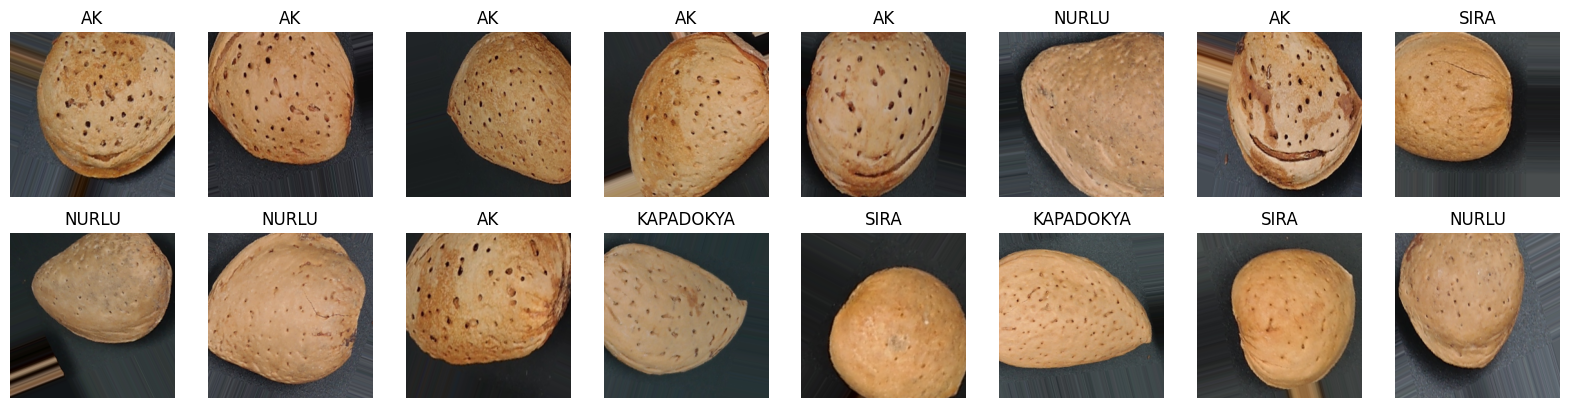

In [12]:
# Function to visualize images with proper classes
def visualize_images(generator, num_images):
    # Get a batch of images and labels
    images, labels = next(generator)
    labels = np.argmax(labels, axis=1)  # Convert one-hot encoding to class labels
    class_labels = list(generator.class_indices.keys())

    # Plot the images in a grid
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(4, 8, i+1)
        plt.imshow(images[i])
        plt.title(class_labels[labels[i]])
        plt.axis('off')
    plt.show()

# Visualize 16 random images from the training set
visualize_images(train_generator, 16)

In [15]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

In [30]:
# Load ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Add a Dropout layer for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
# Combine base model with custom top layers

model = Model(inputs=base_model.input, outputs=predictions)

In [31]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Using a lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [33]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)

print("Training completed.")

Epoch 1/20
39/39 [==============================] - 77s 712ms/step - loss: 4.8024 - accuracy: 0.2727 - val_loss: 2.1257 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 2/20
39/39 [==============================] - 27s 690ms/step - loss: 1.8977 - accuracy: 0.3130 - val_loss: 1.6613 - val_accuracy: 0.4387 - lr: 0.0010
Epoch 3/20
39/39 [==============================] - 25s 642ms/step - loss: 1.6805 - accuracy: 0.3138 - val_loss: 1.5465 - val_accuracy: 0.4871 - lr: 0.0010
Epoch 4/20
39/39 [==============================] - 25s 650ms/step - loss: 1.5456 - accuracy: 0.3660 - val_loss: 1.4630 - val_accuracy: 0.5452 - lr: 0.0010
Epoch 5/20
39/39 [==============================] - 25s 641ms/step - loss: 1.4861 - accuracy: 0.3950 - val_loss: 1.4139 - val_accuracy: 0.3935 - lr: 0.0010
Epoch 6/20
39/39 [==============================] - 25s 650ms/step - loss: 1.4355 - accuracy: 0.3837 - val_loss: 1.3638 - val_accuracy: 0.3355 - lr: 0.0010
Epoch 7/20
39/39 [==============================] - 25s 635ms/st

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [35]:
# Define class names (replace with your class names)
class_names = ['AK', 'NURLU', 'SIRA', 'KAPADOKYA']
# Define data generators for Kaggle dataset paths
validation_data_dir = '/content/valid'

# Define data generator for the validation dataset
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: Set shuffle to False to match predictions with true labels
)

Found 310 images belonging to 4 classes.


In [36]:
# Generate predictions on the validation data
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = validation_generator.classes

10/10 [==============================] - 3s 166ms/step


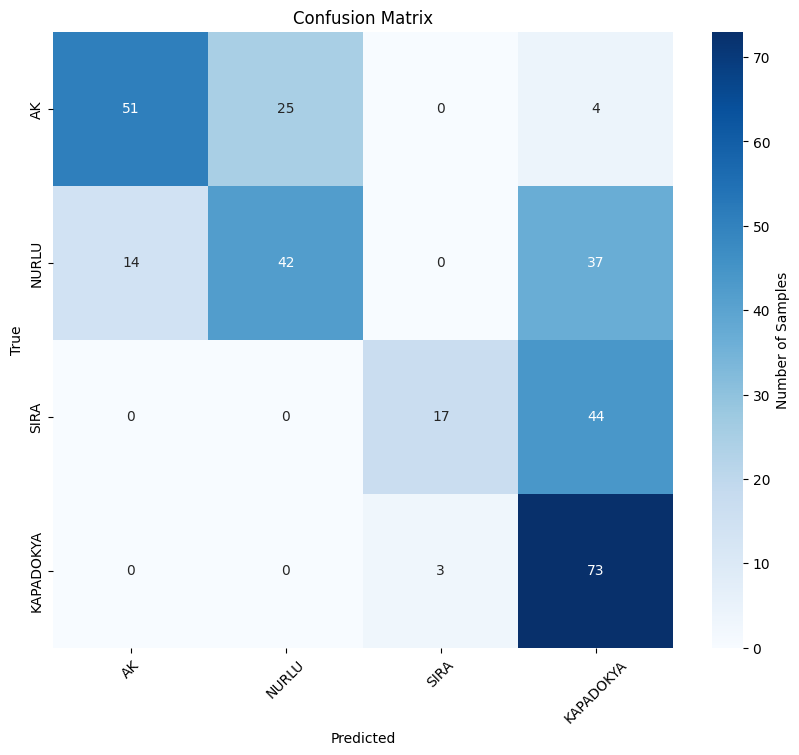

In [37]:
# Create the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with rotated x-axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-38-09731ba7c7b0>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


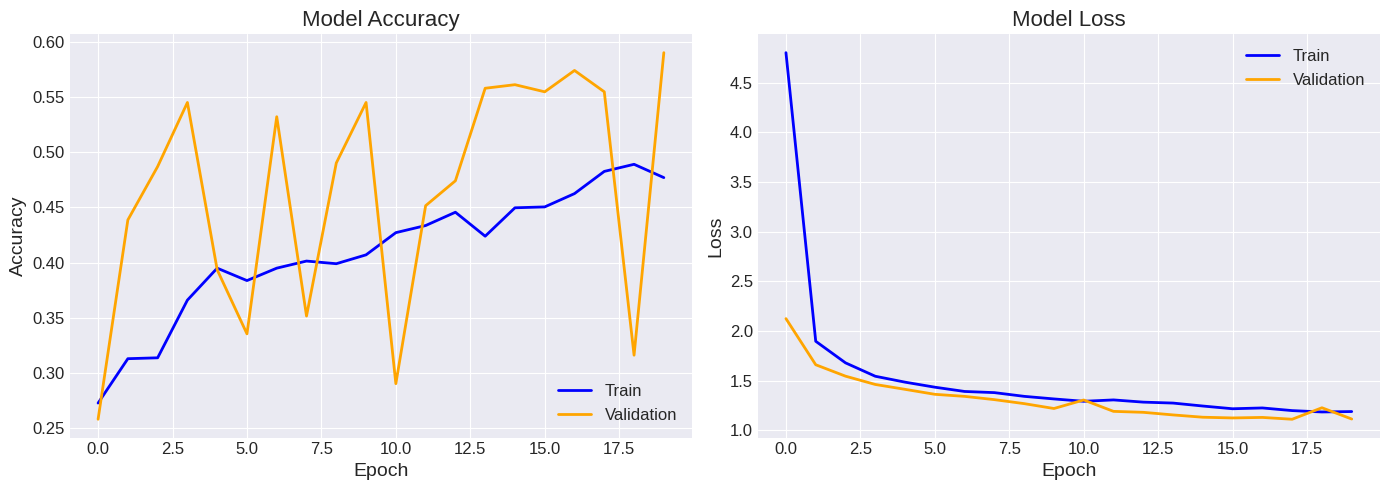

In [38]:
import matplotlib.pyplot as plt

# Set style
plt.style.use('seaborn-darkgrid')

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='blue', linestyle='-', linewidth=2, label='Train')
plt.plot(history.history['val_accuracy'], color='orange', linestyle='-', linewidth=2, label='Validation')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Train')
plt.plot(history.history['val_loss'], color='orange', linestyle='-', linewidth=2, label='Validation')
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

# Adjust layout
plt.tight_layout()

plt.show()

In [39]:
# Print the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

          AK       0.78      0.64      0.70        80
       NURLU       0.63      0.45      0.53        93
        SIRA       0.85      0.28      0.42        61
   KAPADOKYA       0.46      0.96      0.62        76

    accuracy                           0.59       310
   macro avg       0.68      0.58      0.57       310
weighted avg       0.67      0.59      0.57       310

